In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import tables
import pandas as pd
import matplotlib
from scipy.optimize import curve_fit    
pd.set_option('display.max_columns', None)

# Display settings for Jupyter Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Importing custom utility functions
sys.path.insert(0, "/fefs/aswg/workspace/juan.jimenez/cherenkov_transparency_corrections/total_lst1_data_analysis/" + "/../scripts/")
import auxiliar as aux
import lstpipeline

In [2]:
def quadratic_func(x, a, b, c):
    return c * x**2 + b * x + a

p0a, p0b, p0c = -0.44751321, 3.62502037, -1.43611437
p1a, p1b, p1c = -2.89253919, 0.99443581, -0.34013068

### Paths to data and results

In [3]:
# Root path of this script
root = "/fefs/aswg/workspace/juan.jimenez/cherenkov_transparency_corrections/total_lst1_data_analysis/"
# Objects directory
root_objects = root + "objects/"

# Directory of all the night-wise datachecks
root_dchecks = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_"

# Some filenames -------------------
# Filename of the datacheck dictionary
fname_datacheck_dict = root_objects + "tmp_datacheck_dict.pkl"

# Flags for computing or not different parts
# Compute the datacheck dictionary
compute_datacheck_dict = False

# Create needed folders
for dir in [root_objects]:
    if not os.path.exists(dir):
        os.makedirs(dir)

### Extracting dates and parameters of all runs/subruns

In [4]:
%%time
if compute_datacheck_dict:

    run_number   = [] # Run numbers
    srun_number  = [] # Subrun numbers
    timestamps   = [] # Timestamps of each subrun
    time_elapsed = [] # Elapsed time of each subrun
    mean_azimuth = [] # Mean azimuth of each run
    mean_zenith_distance = [] # Mean zenith of each run
    zd_corrected_intensity_at_half_peak_rate = [] # ZD corrected intensity at half peak rate
    intensity_at_half_peak_rate = [] # intensity at half peak rate
    cosmics_peak_rate = []
    zd_corrected_cosmics_peak_rate = []
    zd_corrected_cosmics_rate_at_422_pe = [] # ZD corrected cosmics rate at 422 pe
    zd_corrected_delta_cosmics_rate_at_422_pe = [] # ZD corrected delta cosmics rate at 422 pe
    cosmics_rate_at_422_pe = [] # ZD corrected cosmics rate at 422 pe
    delta_cosmics_rate_at_422_pe = [] # ZD corrected delta cosmics rate at 422 pe
    zd_corrected_cosmics_spectral_index = [] # ZD corrected cosmics spectral index
    cosmics_spectral_index = [] # ZD corrected cosmics spectral index
    zd_corrected_delta_cosmics_spectral_index = [] # ZD corrected delta cosmics spectral index
    light_yield = [] # Light yield
    intensity_spectrum_fit_p_value = []
    diffuse_nsb_std = []
    charge_mean = []
    ra = []
    dec = []

    # All the datachecks for all the nights
    dchecks = np.sort(glob.glob(root_dchecks + "*.h5"))

    # We iterate over all the datachecks
    for i, dcheck in enumerate(dchecks[:]):

        print(f"Analysing... {i:3}/{len(dchecks)}") if i % 30 == 0 else None

        # The datacheck file of the run summary (runwise)
        ds = pd.read_hdf(dcheck, key="runsummary")
        # The datacheck file of the intensity spectrums (subrunwise)
        di = pd.read_hdf(dcheck, key="cosmics_intensity_spectrum")
        # 
        # dp = pd.read_hdf(dcheck, key="pedestals")
        try:
            dp = pd.read_hdf(dcheck, key="pedestals")
            dp_flag = True
        except:
            dp_flag = False
            
        # Iterating over all the entries of each night, the subruns
        for j in range(len(ds)):

            # Reference run number
            runref = ds["runnumber"].iloc[j]
            runra, rundec = ds["mean_ra"].iloc[j], ds["mean_dec"].iloc[j]
            
            # Intensity datacheck for only the subruns of the reference run
            di_run = di.query(f"runnumber == {runref}")
            if dp_flag != False:
                dp_run = dp.query(f"runnumber == {runref}")
            
            # Subrun iteration and storing all the data we are interested in
            for k in range(len(di_run)):

                run_number.append(runref)
                ra.append(runra)
                dec.append(rundec)
                srun_number.append(di_run["subrun"].iloc[k])
                timestamps.append(datetime.fromtimestamp(di_run["time"].iloc[k]))
                time_elapsed.append(di_run["corrected_elapsed_time"].iloc[k])
                mean_azimuth.append(ds["mean_azimuth"].iloc[j])
                mean_zenith_distance.append(np.arccos(di_run["cos_zenith"].iloc[k]))
                zd_corrected_intensity_at_half_peak_rate.append(di_run["ZD_corrected_intensity_at_half_peak_rate"].iloc[k])
                intensity_at_half_peak_rate.append(di_run["intensity_at_half_peak_rate"].iloc[k])
                cosmics_peak_rate.append(di_run["ZD_corrected_cosmics_peak_rate"].iloc[k])
                zd_corrected_cosmics_peak_rate.append(di_run["cosmics_peak_rate"].iloc[k])
                zd_corrected_cosmics_rate_at_422_pe.append(di_run["ZD_corrected_cosmics_rate_at_422_pe"].iloc[k])
                zd_corrected_delta_cosmics_rate_at_422_pe.append(di_run["ZD_corrected_delta_cosmics_rate_at_422_pe"].iloc[k])
                cosmics_rate_at_422_pe.append(di_run["cosmics_rate_at_422_pe"].iloc[k])
                delta_cosmics_rate_at_422_pe.append(di_run["delta_cosmics_rate_at_422_pe"].iloc[k])
                zd_corrected_cosmics_spectral_index.append(di_run["ZD_corrected_cosmics_spectral_index"].iloc[k])
                cosmics_spectral_index.append(di_run["cosmics_spectral_index"].iloc[k])
                zd_corrected_delta_cosmics_spectral_index.append(di_run["delta_cosmics_spectral_index"].iloc[k])
                light_yield.append(di_run["light_yield"].iloc[k])
                intensity_spectrum_fit_p_value.append(di_run["intensity_spectrum_fit_p_value"].iloc[k])
                diffuse_nsb_std.append(di_run["diffuse_nsb_std"].iloc[k])

                if dp_flag != False:
                    try:
                        charge_mean.append(dp_run["charge_mean"].iloc[k])
                    except:
                        charge_mean.append(np.nan)
                else:
                    charge_mean.append(np.nan)

    print(f"Analysing... {len(dchecks):3}/{len(dchecks)}\n")

    # Now we are going to sort looking to the timestamps
    _, run_number = aux.sort_based(run_number, timestamps)
    _, ra = aux.sort_based(ra, timestamps)
    _, dec = aux.sort_based(dec, timestamps)
    _, srun_number = aux.sort_based(srun_number, timestamps)
    _, time_elapsed = aux.sort_based(time_elapsed, timestamps)
    _, mean_azimuth = aux.sort_based(mean_azimuth, timestamps)
    _, mean_zenith_distance = aux.sort_based(mean_zenith_distance, timestamps)
    _, zd_corrected_intensity_at_half_peak_rate = aux.sort_based(zd_corrected_intensity_at_half_peak_rate, timestamps)
    _, intensity_at_half_peak_rate = aux.sort_based(intensity_at_half_peak_rate, timestamps)
    _, cosmics_peak_rate = aux.sort_based(cosmics_peak_rate, timestamps)
    _, zd_corrected_cosmics_peak_rate = aux.sort_based(zd_corrected_cosmics_peak_rate, timestamps)
    _, zd_corrected_cosmics_rate_at_422_pe = aux.sort_based(zd_corrected_cosmics_rate_at_422_pe, timestamps)
    _, zd_corrected_delta_cosmics_rate_at_422_pe = aux.sort_based(zd_corrected_delta_cosmics_rate_at_422_pe, timestamps)
    _, cosmics_rate_at_422_pe = aux.sort_based(cosmics_rate_at_422_pe, timestamps)
    _, delta_cosmics_rate_at_422_pe = aux.sort_based(delta_cosmics_rate_at_422_pe, timestamps)
    _, zd_corrected_cosmics_spectral_index = aux.sort_based(zd_corrected_cosmics_spectral_index, timestamps)
    _, cosmics_spectral_index = aux.sort_based(cosmics_spectral_index, timestamps)
    _, zd_corrected_delta_cosmics_spectral_index = aux.sort_based(zd_corrected_delta_cosmics_spectral_index, timestamps)
    _, intensity_spectrum_fit_p_value = aux.sort_based(intensity_spectrum_fit_p_value, timestamps)
    _, diffuse_nsb_std = aux.sort_based(diffuse_nsb_std, timestamps)
    _, charge_mean = aux.sort_based(charge_mean, timestamps)
    timestamps, light_yield = aux.sort_based(light_yield, timestamps)

    # Creating the data dictionary
    dict_dcheck = {
        "run" : np.array(run_number),
        "ra" : np.array(ra),
        "dec" : np.array(dec),        
        "srun" : np.array(srun_number),
        "time" : np.array(timestamps),
        "telapsed" : np.array(time_elapsed),
        "az" : np.rad2deg(mean_azimuth),
        "zd" : np.rad2deg(mean_zenith_distance),
        "ZD_corrected_intensity_at_half_peak_rate" : np.array(zd_corrected_intensity_at_half_peak_rate),
        "intensity_at_half_peak_rate" : np.array(intensity_at_half_peak_rate),
        "cosmics_peak_rate" : np.array(cosmics_peak_rate),
        "ZD_corrected_cosmics_peak_rate" : np.array(zd_corrected_cosmics_peak_rate),
        "ZD_corrected_cosmics_rate_at_422_pe" : np.array(zd_corrected_cosmics_rate_at_422_pe),
        "ZD_corrected_delta_cosmics_rate_at_422_pe" : np.array(zd_corrected_delta_cosmics_rate_at_422_pe),
        "cosmics_rate_at_422_pe" : np.array(cosmics_rate_at_422_pe),
        "delta_cosmics_rate_at_422_pe" : np.array(delta_cosmics_rate_at_422_pe),
        "ZD_corrected_cosmics_spectral_index" : np.array(zd_corrected_cosmics_spectral_index),
        "cosmics_spectral_index" : np.array(cosmics_spectral_index),
        "delta_cosmics_spectral_index" : np.array(zd_corrected_delta_cosmics_spectral_index),
        "intensity_spectrum_fit_p_value" : np.array(intensity_spectrum_fit_p_value),
        "diffuse_nsb_std" : np.array(diffuse_nsb_std),
        "light_yield" : np.array(light_yield),
        "charge_mean" : np.array(charge_mean),
    }        

    # Saving the objects in the objects directory
    with open(fname_datacheck_dict, 'wb') as f:
        pickle.dump(dict_dcheck, f, pickle.HIGHEST_PROTOCOL)  
else:
    # To read the file:
    with open(fname_datacheck_dict, 'rb') as f:
            dict_dcheck = pickle.load(f)    

CPU times: user 223 ms, sys: 211 ms, total: 435 ms
Wall time: 433 ms


### Creating the total dictionary run-subrun-wise

In [5]:
%%time
total_dict = {}

# We create an entry per run
for run in np.unique(dict_dcheck["run"]):
    total_dict[run] = {}

# Converting dcheck dictionary to total dictionary
for i in range(len(dict_dcheck["run"])):

    total_dict[dict_dcheck["run"][i]][dict_dcheck["srun"][i]] = {
        "ra" : dict_dcheck["ra"][i],
        "dec" : dict_dcheck["dec"][i],
        "time" : dict_dcheck["time"][i],
        "telapsed" : dict_dcheck["telapsed"][i],
        "az" : dict_dcheck["az"][i],
        "zd" : dict_dcheck["zd"][i],
        "ZD_corrected_intensity_at_half_peak_rate" : dict_dcheck["ZD_corrected_intensity_at_half_peak_rate"][i],
        "intensity_at_half_peak_rate" : dict_dcheck["intensity_at_half_peak_rate"][i],
        "cosmics_peak_rate" : dict_dcheck["cosmics_peak_rate"][i],
        "ZD_corrected_cosmics_peak_rate" : dict_dcheck["ZD_corrected_cosmics_peak_rate"][i],
        "ZD_corrected_cosmics_rate_at_422_pe" : dict_dcheck["ZD_corrected_cosmics_rate_at_422_pe"][i],
        "ZD_corrected_delta_cosmics_rate_at_422_pe" : dict_dcheck["ZD_corrected_delta_cosmics_rate_at_422_pe"][i],
        "cosmics_rate_at_422_pe" : dict_dcheck["cosmics_rate_at_422_pe"][i],
        "delta_cosmics_rate_at_422_pe" : dict_dcheck["delta_cosmics_rate_at_422_pe"][i],
        "ZD_corrected_cosmics_spectral_index" : dict_dcheck["ZD_corrected_cosmics_spectral_index"][i],
        "cosmics_spectral_index" : dict_dcheck["cosmics_spectral_index"][i],
        "delta_cosmics_spectral_index" : dict_dcheck["delta_cosmics_spectral_index"][i],        
        "intensity_spectrum_fit_p_value" : dict_dcheck["intensity_spectrum_fit_p_value"][i],      
        "diffuse_nsb_std" : dict_dcheck["diffuse_nsb_std"][i], 
        "light_yield" : dict_dcheck["light_yield"][i],
        "charge_mean" : dict_dcheck["charge_mean"][i],
    }

CPU times: user 3.61 s, sys: 461 ms, total: 4.08 s
Wall time: 4.07 s


In [6]:
%%time 
# Run independent dictionary (merged)
merged_dict = {
    'time': [],
     'telapsed': [],
     'az': [],
     'zd': [],
     'ra': [],
     'dec': [],
     'ZD_corrected_intensity_at_half_peak_rate': [],
     'intensity_at_half_peak_rate': [],
     'cosmics_peak_rate': [],
     'ZD_corrected_cosmics_peak_rate': [],
     'ZD_corrected_cosmics_rate_at_422_pe': [],
     'ZD_corrected_delta_cosmics_rate_at_422_pe': [],
     'cosmics_rate_at_422_pe': [],
     'delta_cosmics_rate_at_422_pe': [],
     'ZD_corrected_cosmics_spectral_index': [],
     'cosmics_spectral_index': [],
     'delta_cosmics_spectral_index': [],
     'intensity_spectrum_fit_p_value': [],
     'diffuse_nsb_std': [],
     'light_yield': [],
     'charge_mean': [],
}
for i, run in enumerate(total_dict.keys()):

    print(f"Analysing... {i:3}/{len(total_dict.keys())}") if i % 500 == 0 else None
    
    for srun in total_dict[run].keys():
        for key in merged_dict.keys():
            merged_dict[key].append(total_dict[run][srun][key])
        

Analysing...   0/7771
Analysing... 500/7771
Analysing... 1000/7771
Analysing... 1500/7771
Analysing... 2000/7771
Analysing... 2500/7771
Analysing... 3000/7771
Analysing... 3500/7771
Analysing... 4000/7771
Analysing... 4500/7771
Analysing... 5000/7771
Analysing... 5500/7771
Analysing... 6000/7771
Analysing... 6500/7771
Analysing... 7000/7771
Analysing... 7500/7771
CPU times: user 4.6 s, sys: 569 ms, total: 5.17 s
Wall time: 5.16 s


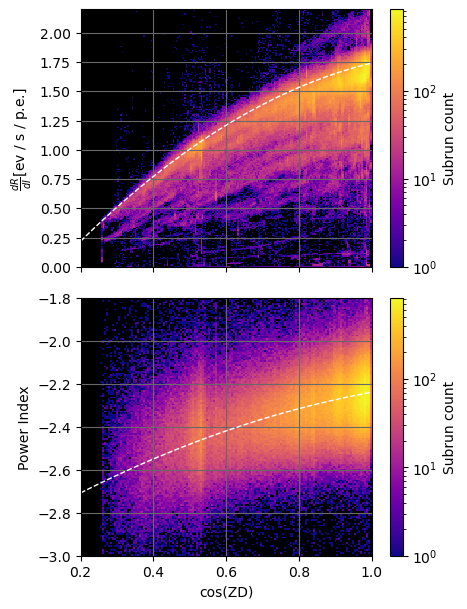

In [7]:
nanmask = np.isnan(merged_dict["cosmics_rate_at_422_pe"])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.5, 6), sharex=True)
hist1 = ax1.hist2d(
    np.cos(np.deg2rad(merged_dict["zd"]))[~nanmask], 
    np.array(merged_dict["cosmics_rate_at_422_pe"])[~nanmask], 
    bins=(np.linspace(0.2, 1, 200), np.linspace(0, 2.2, 200)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)

hist2 = ax2.hist2d(
    np.cos(np.deg2rad(merged_dict["zd"]))[~nanmask], 
    np.array(merged_dict["cosmics_spectral_index"])[~nanmask], 
    bins=(np.linspace(0.2, 1, 150), np.linspace(-3, -1.8, 150)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)
fig.colorbar(hist1[3], label="Subrun count")
fig.colorbar(hist2[3], label="Subrun count")
for ax in [ax1, ax2]:
    ax.set_facecolor("k")
    ax.grid(color="dimgray")
fig.tight_layout()
ax2.set_xlabel("cos(ZD)")
ax1.set_ylabel("$\\frac{dR}{dI}$[ev / s / p.e.]")
ax2.set_ylabel("Power Index")


x_fit = np.linspace(0.2, 1, 100)
y_fit = quadratic_func(x_fit, p1a, p1b, p1c)
ax2.plot(x_fit, y_fit, 'w', lw=1, ls="--")

x_fit = np.linspace(0.2, 1, 100)
y_fit = quadratic_func(x_fit, p0a, p0b, p0c)
ax1.plot(x_fit, y_fit, 'w', lw=1, ls="--")


plt.savefig(root + f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

Parameters:
* Peak rate
* Half peak intensity
* PWL rate
* PWL index
* RA
* DEC
* az
* dec
* NSB

In [8]:
labels_multiplot = [
    "zd",
    "az",
    "ra",
    "dec",
    "charge_mean",
    "light_yield",
    "cosmics_peak_rate",
    "intensity_at_half_peak_rate",
    "cosmics_spectral_index",
    "cosmics_rate_at_422_pe",
    "intensity_spectrum_fit_p_value"
]

data_multiplot = [
    np.cos(np.deg2rad(merged_dict["zd"])),
    merged_dict["az"],
    merged_dict["charge_mean"],
    merged_dict["light_yield"],
    merged_dict["cosmics_peak_rate"],
    merged_dict["intensity_at_half_peak_rate"],
    merged_dict["cosmics_spectral_index"],
    merged_dict["cosmics_rate_at_422_pe"],
]

labels_multiplot = [
    "cos(ZD)",
    "AZ [deg]",
    "NSB [p.e.]",
    "LY",
    "Cosmics peak\nrate [ev/s/p.e.]",
    "I @ 1/2 peak\nrate [p.e.]",
    "spectral index",
    "$\\frac{dR}{dI}$ [ev/s/p.e.]",
]
Nbins = 150

bins_multiplot = [
    np.linspace(0.2, 1, Nbins),
    np.linspace(0, 360, Nbins),
    np.linspace(1, 6, Nbins),
    np.linspace(0, 1.5, Nbins),
    np.linspace(0, 80, Nbins),
    np.linspace(20, 80, Nbins),
    np.linspace(-3, -1, Nbins),
    np.linspace(0, 2.5, Nbins),
]

ticks_multiplot = [
    [0.25, 0.5, 0.75],
    [100, 200, 300],
    [2, 3, 4, 5],
    [0.25, 0.75, 1.25],
    [20, 40, 60],
    [30, 50, 70], 
    [-2.5, -2, -1.5],
    [0.5, 1, 1.5, 2],
]

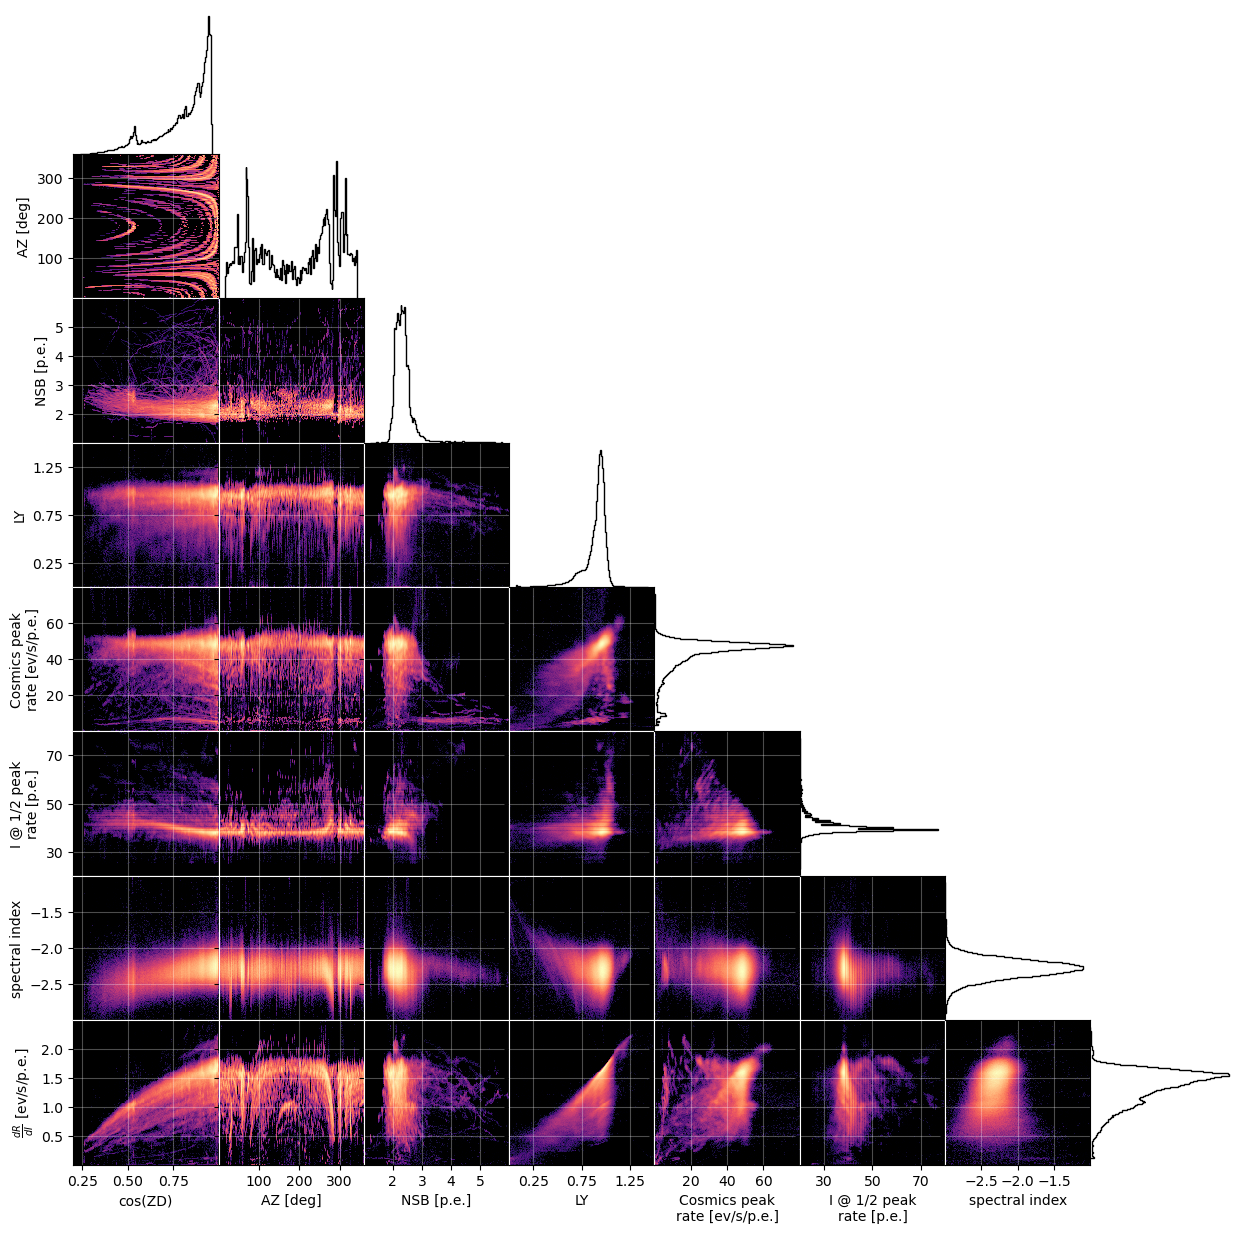

In [9]:
fig, ax = plt.subplots(len(bins_multiplot), len(bins_multiplot), figsize=(15, 15),)

for i in range(len(ax)):
    for j in range(len(ax[i])):


        x, y = np.array(data_multiplot[j]), np.array(data_multiplot[i])
        nanmask = ~(np.isnan(x) | np.isnan(y))
        
        if j > i:
            ax[i][j].set_axis_off()
        elif j == i:
            ax[i][j].set_axis_off()
            if i >= len(ax) / 2:
                ax[i][j].hist(x[nanmask], bins=bins_multiplot[i], histtype="step", orientation="horizontal", color="k")
            else:
                ax[i][j].hist(x[nanmask], bins=bins_multiplot[i], histtype="step", color="k")

        else:
            ax[i][j].hist2d(x[nanmask], 
                            y[nanmask], 
                            bins=(bins_multiplot[j], bins_multiplot[i]), 
                            norm=matplotlib.colors.LogNorm(), 
                            cmap="magma"
                            )
            ax[i][j].set_facecolor("k")
            ax[i][j].grid(color="w", alpha=0.3)

            ax[i][j].spines['bottom'].set_color("w")
            ax[i][j].spines['top'].set_color("w") 
            ax[i][j].spines['right'].set_color("w")
            ax[i][j].spines['left'].set_color("w")

            ax[i][j].set_xticks(ticks_multiplot[j])
            ax[i][j].set_yticks(ticks_multiplot[i])
            
        if j - i == -1 :
            ax[i][j].spines['top'].set_color("k") 
            ax[i][j].spines['right'].set_color("k")
        if i != (len(ax)- 1):
            ax[i][j].set_xticklabels([])
        else:
            ax[i][j].spines['bottom'].set_color("k")
            ax[i][j].set_xlabel(labels_multiplot[j])
            
        if j != 0:
            ax[i][j].set_yticklabels([])
        else:
            ax[i][j].spines['left'].set_color("k")
            ax[i][j].set_ylabel(labels_multiplot[i])
      
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig(root + f"plots/total.png", bbox_inches="tight", dpi=400)
plt.show()

### Testing some runs with the peak parameters

In [10]:
runs = [
   2853, 2922, 2923, 2924, 2934, 2950, 2959, 2960, 2965, 2967, 2968,
   2969, 2971, 2972, 2974, 2975, 2977, 2988, 2989, 2990, 2991, 2992,
   3009, 3011, 3012, 3087, 3088, 3089, 3093, 3095, 3096, 3097, 3098,
   3100, 3144, 3169, 3170, 3231, 3232, 3235, 3236, 3237, 3243, 3244,
   3245, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274,
   3275, 3276, 3277, 3278, 3318, 3319, 3320, 3321, 3328, 3329, 3338,
   3339, 3340, 3355, 3356, 3382, 3515, 3516, 3583, 3584, 3585, 3586,
   3598, 3599, 3600, 3601, 3631, 3632, 3633, 3634, 3635, 3636, 3637,
   3638, 3639, 3650, 3651, 3652, 3653, 3655, 3672, 3673, 3674, 3675,
   3676, 3677, 3678, 3679, 3680, 3683, 3684, 3703, 3704, 3705, 3706,
   3707, 3708, 3709, 3710, 3711, 3712, 3725, 3730, 3894, 3895, 3953,
   3956, 3957, 3959, 3961, 3962, 3983, 4008, 4009, 4010, 4011, 4012,
   4013, 4015, 4033, 4034, 4035, 4036, 4067, 4068, 4069, 4073, 4074,
   4075, 4086, 4087, 4088, 4089, 4090, 4094, 4125, 4126, 4127, 4128,
   4129, 4145, 4146, 4147, 4148, 4149, 7084, 7087, 7088, 7097, 7099,
   7100, 7101, 7102, 7106, 7133, 7134, 7135, 7136, 7137, 7140, 7141,
   7142, 7143, 7168, 7169, 7170, 7172, 7173, 7174, 7196, 7197, 7201,
   7202, 7227, 7228, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7253,
   7254, 7275, 7276, 7277, 7278, 7279, 7282, 7301, 7302, 7304
]

timestamps = []
par1, par2 = [], []
for r in runs:
    tmp_dict = total_dict[r]
    timestamps.append(tmp_dict[0]["time"])
    tmp1, tmp2 = [], []
    for srun in tmp_dict:
        tmp1.append(tmp_dict[srun]["ZD_corrected_cosmics_peak_rate"])
        tmp2.append(tmp_dict[srun]["ZD_corrected_intensity_at_half_peak_rate"])

    par1.append(np.mean(tmp1))
    par2.append(np.mean(tmp2))


fluxes = [ 
        4.93123174e-11,  2.03790424e-10,  1.83281404e-10,  2.14813896e-10,
        1.81092356e-10,  1.86754145e-10,  2.02347758e-10,  6.20650332e-12,
        2.13200764e-10,  2.00570451e-10,  2.06413493e-10,  2.22320218e-10,
        1.99115767e-10,  1.98911786e-10,  1.81669883e-10,  1.99642342e-10,
        1.96860344e-10,  1.54426161e-10,  1.75240121e-10,  1.71247977e-10,
        1.83934399e-10,  1.73580378e-10,  1.79529553e-10,  1.86081593e-10,
        2.10588204e-10,  2.40948391e-10,  2.08499967e-10,  1.87056498e-10,
        1.83916227e-10,  2.22266228e-10,  2.10369489e-10,  1.95123877e-10,
        1.93376622e-10,  1.28158567e-10,  2.13789800e-10,  1.77805366e-10,
        1.91849694e-10,  2.11782876e-10,  2.13525340e-10,  1.94206802e-10,
        1.93730323e-10,  2.08962823e-10,  1.87132892e-10,  2.22807413e-10,
        2.18479532e-10,  2.13586976e-10,  2.02887339e-10,  2.03826290e-10,
        1.97224240e-10,  2.06852050e-10,  2.05402591e-10,  2.33681370e-10,
        2.21295882e-10,  2.43114798e-10,  2.27609359e-10,  2.02946448e-10,
        2.11664396e-10,  1.83768591e-10,  2.13627342e-10,  2.49866892e-10,
        2.09188374e-10,  2.11311331e-10,  2.32094867e-10,  1.83338436e-10,
        2.32262591e-10,  2.00889487e-10,  2.19180981e-10,  1.92967707e-10,
        2.13885922e-10,  2.24673074e-10,  2.44511288e-10,  3.81314605e-10,
        1.69065001e-10,  1.72772662e-10,  1.65001224e-10,  1.90735393e-10,
        1.73059027e-10,  1.96123649e-10,  2.25409616e-10,  1.88413329e-10,
        1.82038216e-10,  1.52081236e-10,  1.83213294e-10,  2.11790614e-10,
        2.17748185e-10,  1.96894947e-10,  2.14839979e-10,  2.03520112e-10,
        2.06989865e-10,  2.16871695e-10,          np.nan,  1.77247755e-10,
        2.18546308e-10,  1.94622076e-10,  2.26615921e-10,  2.12383335e-10,
        1.89818986e-10,  2.08412717e-10,  2.02292745e-10,  1.71183069e-10,
        1.83074768e-10,  1.98646000e-10,  1.96125859e-10,  1.94205979e-10,
        2.14680031e-10,  1.98144058e-10,  1.43385580e-10,  1.95492616e-10,
        2.18227635e-10,  1.58377578e-10,  1.77687233e-10,  1.86750002e-10,
        1.92369987e-10,  1.98054000e-10,  1.90197583e-10,  1.87265908e-10,
        4.03879565e-11,  2.73597841e-12,  2.41514893e-10,  1.37347122e-10,
                np.nan,  1.01652012e-10,  6.69341153e-11,  6.11117895e-11,
        1.25783026e-10,  2.44697706e-10, -2.41787406e-11,  1.75955605e-10,
        1.71593348e-10,  1.55835897e-10,  1.66800653e-10,  2.29674257e-10,
        2.59758387e-10,  3.01100831e-10,  2.34460596e-10,  1.83866291e-10,
        2.02207143e-10,  1.94502403e-10,  2.34269146e-10,  1.87240725e-10,
        1.98938906e-10,  2.55488157e-10,  2.14227695e-10,  2.31753463e-10,
        1.86084549e-10,  2.35514511e-10,  2.24598292e-10,  1.63653263e-10,
        2.21180343e-10,  2.19288699e-10,  1.82142358e-10,  2.23985409e-10,
        1.64898497e-10,  2.11909047e-10,  5.10363702e-10,  2.03293163e-10,
        1.79786116e-10,  2.07848315e-10,  1.58928276e-10,  1.94186207e-10,
        1.81091317e-10,  1.92304138e-10,  1.57698797e-10,  2.03163233e-10,
        1.91735311e-10,  2.00116366e-10,  2.22443063e-10,  1.95475736e-10,
        1.75078848e-10,  2.24477232e-10,  2.24690743e-10,  2.00433952e-10,
        1.82241835e-10,  2.12939113e-10,  1.87308945e-10,  1.55090930e-10,
        1.47107032e-10,  1.73000679e-11,  6.49946325e-11,  2.21641036e-10,
        2.06827138e-10,  2.81582208e-10,  1.57761585e-10, -2.81860330e-11,
        1.68294961e-10,  2.08393143e-10,  1.97233060e-10,  2.81805905e-10,
        2.02425080e-10,  2.27570504e-10,  1.83617419e-10,  1.75652859e-10,
        1.74550474e-10,  2.18065665e-10,  1.91851322e-10,  2.12899689e-10,
        1.71637717e-10,  2.15444670e-10,  2.19285231e-10,  2.17325931e-10,
        2.17548266e-10,  1.99140225e-10,  2.12247446e-10,  2.20979012e-10,
        2.13958464e-10,  2.07024425e-10,  2.27960937e-10,  2.38891846e-10
]
fluxes = np.array(fluxes)

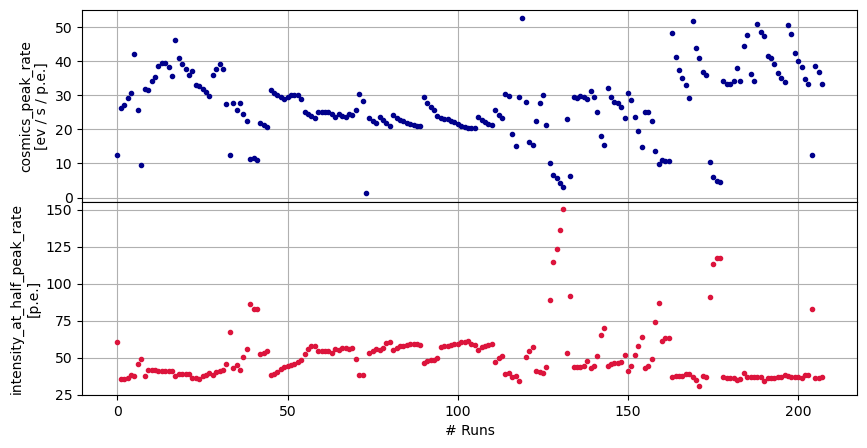

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

ax1.plot(par1, color="darkblue", marker=".", ls="")
ax2.plot(par2, color="crimson", marker=".", ls="")
# ax1.set_ylim(0.7, 1.3)
ax2.set_ylim(25, 155)
ax1.grid()
ax2.grid()
ax2.set_xlabel("# Runs")
plt.subplots_adjust(wspace=0, hspace=0)

ax1.set_ylabel("cosmics_peak_rate\n[ev / s / p.e.]")
ax2.set_ylabel("intensity_at_half_peak_rate\n[p.e.]")

# plt.savefig(root + f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

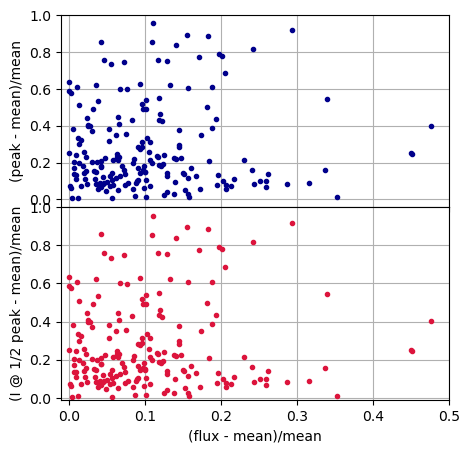

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5), sharex=True)

r1 = np.abs(par1 - np.mean(par1)) / np.mean(par1)
r2 = np.abs(par2 - np.mean(par2)) / np.mean(par2)
rg = np.abs(fluxes - np.nanmean(fluxes)) / np.nanmean(fluxes)

ax1.plot(rg, r1, color="darkblue", marker=".", ls="")
ax2.plot(rg, r1, color="crimson", marker=".", ls="")

ax1.grid()
ax2.grid()
plt.subplots_adjust(wspace=0, hspace=0)

# ax1.set_ylim(-0.3, 10)
# ax2.set_ylim(-0.3, 10)
ax1.set_xlim(-0.01, 0.5)
ax2.set_ylim(-0.01, 1)
ax1.set_ylabel("(peak - mean)/mean")
ax2.set_xlabel("(flux - mean)/mean")
ax2.set_ylabel("(I @ 1/2 peak - mean)/mean")

plt.savefig(root + f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()